In [2]:
import os
from pathlib import Path

# Ensure CWD is repo root even if notebook lives in notebooks/
HERE = Path.cwd()
if HERE.name == "notebooks":
    os.chdir(HERE.parent)

print("CWD:", Path.cwd())

OUT_DIR = Path("outputs/figures/01_data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("Saving to:", OUT_DIR.resolve())

CWD: /Users/samyuktareddy/Desktop/MOF Gas absorption
Saving to: /Users/samyuktareddy/Desktop/MOF Gas absorption/outputs/figures/01_data


In [3]:
import pandas as pd
from pathlib import Path

# MOFCSD (original structural table)
mofcsd_candidates = [
    Path("data/raw/MOFCSD.csv"),
    Path("data/MOFCSD.csv"),
    *list(Path("data").rglob("MOFCSD.csv"))
]
MOFCSD_PATH = next((p for p in mofcsd_candidates if p.exists()), None)
if MOFCSD_PATH is None:
    raise FileNotFoundError("Could not find MOFCSD.csv under data/. Please locate it and update paths.")

mof = pd.read_csv(MOFCSD_PATH)
print("MOFCSD loaded:", MOFCSD_PATH, "rows=", len(mof), "cols=", len(mof.columns))
print("Columns:", list(mof.columns))

# merged labeled table
LABELED_PATH = Path("data/processed/MOFCSD_with_co2_labels.csv")
if not LABELED_PATH.exists():
    raise FileNotFoundError(f"Missing {LABELED_PATH}. Run merge_labels_into_mofcsd.py first.")
lab = pd.read_csv(LABELED_PATH)
print("Labeled table loaded:", LABELED_PATH, "rows=", len(lab), "cols=", len(lab.columns))

# overlap file (optional, but you created it)
OVERLAP_PATH = Path("data/processed/overlap_refcodes.txt")
overlap = None
if OVERLAP_PATH.exists():
    overlap = [x.strip().upper() for x in OVERLAP_PATH.read_text().splitlines() if x.strip()]
    print("Overlap refcodes:", len(overlap))
else:
    print("Note: overlap_refcodes.txt not found (optional).")


MOFCSD loaded: data/raw/MOFCSD.csv rows= 14296 cols= 6
Columns: ['refcode', 'linker SMILES', 'metal', 'Largest Cavity Diameter', 'Pore Limiting Diameter', 'Largest Free Sphere']
Labeled table loaded: data/processed/MOFCSD_with_co2_labels.csv rows= 14296 cols= 7
Overlap refcodes: 363


In [4]:
import numpy as np

id_col = "refcode"
y_col = "co2_uptake"

mof_ids = mof[id_col].astype(str).str.upper().str.strip()
lab_ids = lab[id_col].astype(str).str.upper().str.strip()

total_mofcsd = mof_ids.nunique()
total_labeled = int(lab[y_col].notna().sum())

# if overlap list exists, use it, else compute overlap from labeled non-null
if overlap is None:
    overlap_set = set(lab.loc[lab[y_col].notna(), id_col].astype(str).str.upper().str.strip())
else:
    overlap_set = set(overlap)

overlap_count = len(overlap_set)

unlabeled_count = total_mofcsd - overlap_count

(total_mofcsd, overlap_count, unlabeled_count, total_labeled)

(14296, 363, 13933, 363)

Figure 1: Dataset coverage: MOFCSD vs CO2 - labeled subset

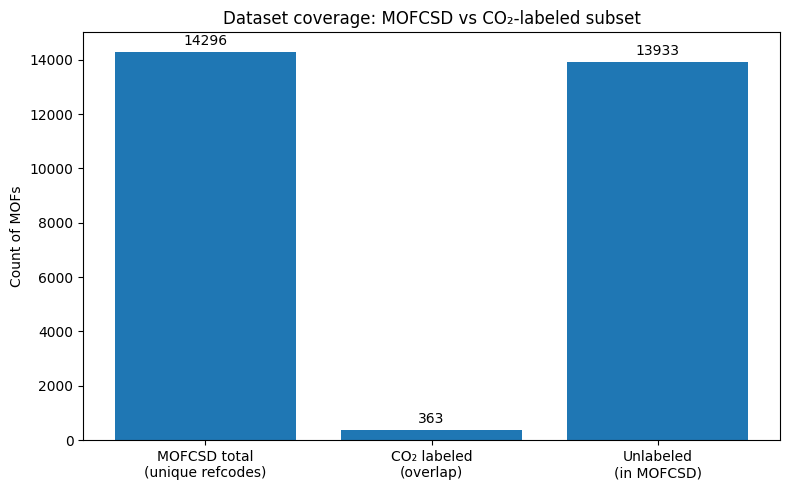

Saved: outputs/figures/01_data/id_overlap_counts_v1.png


In [5]:
import matplotlib.pyplot as plt

labels = ["MOFCSD total\n(unique refcodes)", "CO₂ labeled\n(overlap)", "Unlabeled\n(in MOFCSD)"]
values = [total_mofcsd, overlap_count, unlabeled_count]

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.ylabel("Count of MOFs")
plt.title("Dataset coverage: MOFCSD vs CO₂-labeled subset")

# add value labels
for i, v in enumerate(values):
    plt.text(i, v + max(values)*0.01, str(v), ha="center", va="bottom", fontsize=10)

out = OUT_DIR / "id_overlap_counts_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

Although the MOFCSD dataset contains over 14,000 unique MOF structures, only 363 of these have experimentally measured CO₂ uptake values under the chosen conditions. This extreme label sparsity (≈2.5%) creates a few-shot learning scenario, where conventional supervised learning approaches are insufficient. However, the availability of a large number of unlabeled but structurally related MOFs enables the use of graph-based semi-supervised learning.

Figure 2: CO2 uptake distribution

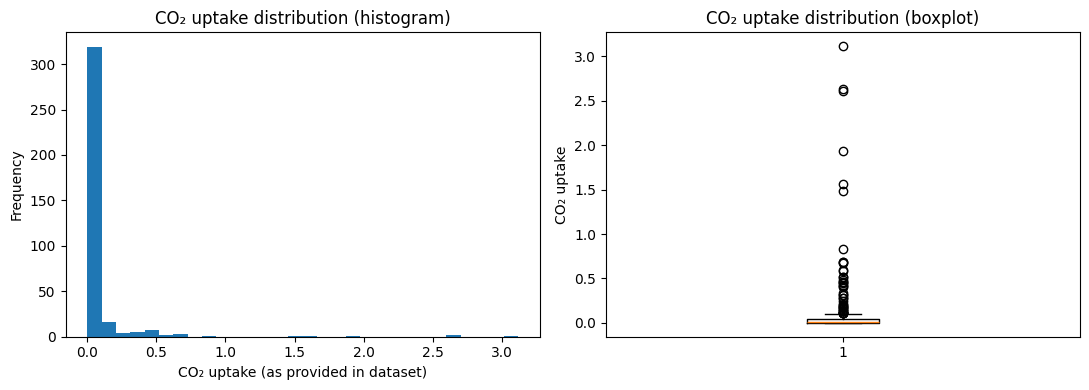

Saved: outputs/figures/01_data/co2_uptake_distribution_v1.png
Summary stats:
n = 363
min/median/max = 0.0 0.0096646 3.1162271
mean/std = 0.08761283774104683 0.31053731264195344


In [6]:
import matplotlib.pyplot as plt
import numpy as np

vals = lab[y_col].dropna().astype(float).values

fig = plt.figure(figsize=(11,4))

# Histogram
ax1 = fig.add_subplot(1,2,1)
ax1.hist(vals, bins=30)
ax1.set_title("CO₂ uptake distribution (histogram)")
ax1.set_xlabel("CO₂ uptake (as provided in dataset)")
ax1.set_ylabel("Frequency")

# Boxplot
ax2 = fig.add_subplot(1,2,2)
ax2.boxplot(vals, vert=True)
ax2.set_title("CO₂ uptake distribution (boxplot)")
ax2.set_ylabel("CO₂ uptake")

out = OUT_DIR / "co2_uptake_distribution_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

print("Summary stats:")
print("n =", len(vals))
print("min/median/max =", float(np.min(vals)), float(np.median(vals)), float(np.max(vals)))
print("mean/std =", float(np.mean(vals)), float(np.std(vals)))

The CO₂ uptake values show a highly right-skewed distribution, where the majority of MOFs exhibit very low adsorption capacity, while only a small subset achieves high uptake. This imbalance makes direct regression challenging, as errors on rare high-uptake MOFs disproportionately affect model performance. The boxplot further confirms the presence of strong outliers, highlighting the need for models that can generalize under data sparsity.

Figure 3: Label scarcity in MOFCSD (few shot reality) 

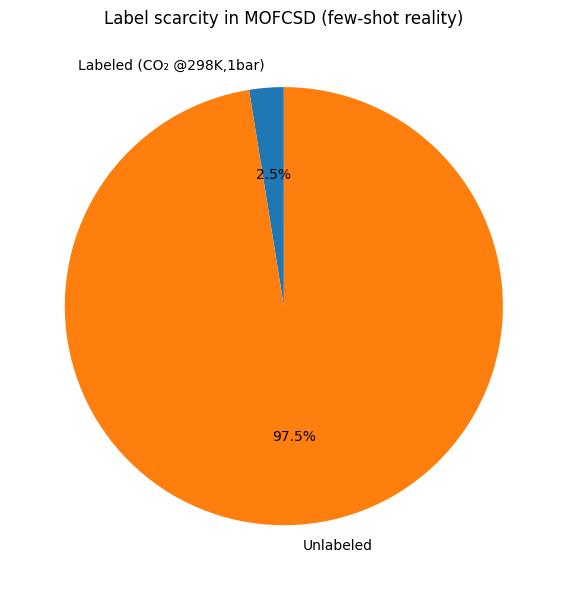

Saved: outputs/figures/01_data/labeled_fraction_v1.png


In [7]:
import matplotlib.pyplot as plt

sizes = [overlap_count, unlabeled_count]
names = ["Labeled (CO₂ @298K,1bar)", "Unlabeled"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=names, autopct="%1.1f%%", startangle=90)
plt.title("Label scarcity in MOFCSD (few-shot reality)")

out = OUT_DIR / "labeled_fraction_v1.png"
plt.tight_layout()
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)

The pie chart highlights the severe imbalance between labeled and unlabeled MOFs in the dataset. With only about 2.5% of nodes having CO₂ adsorption labels, the problem naturally falls into the few-shot learning regime. This visualization emphasizes why leveraging relational information through graph structures is essential for improving predictive performance under limited labeled data.

In [8]:
sample = lab[lab[y_col].notna()].sample(10, random_state=42)[[id_col, y_col]]
sample

,refcode,co2_uptake
6791,MIDRAT,0.015524
1117,CAWVIH,0.010783
714,BEPMEQ,0.001934
11561,VACFOV,0.017116
2357,EGELUY01,0.011864
7471,NIHBIQ02,0.001615
3320,FUFREE,0.063699
4591,IFEQAN,0.006766
10008,SAHYOQ04,0.000706
4969,IYUJAO,0.013202
